In [1]:
import numpy as np
import os
import matplotlib.pyplot as pl
np.random.seed(42)
from google.colab import drive

In [ ]:
#print(os.getcwd())
#print(os.listdir('.'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#print(os.getcwd())
#print(os.listdir('./drive/MyDrive/Assignment1DL/'))

PREPROCESSING

In [36]:
loc = './drive/MyDrive/Assignment1DL/'
test_data_source = np.load(loc + 'test_data.npy')
test_label_source = np.load(loc + 'test_label.npy')
train_data_source = np.load(loc + 'train_data.npy')
train_label_source = np.load(loc + 'train_label.npy')

print(test_data_source.shape)
print(test_label_source.shape)
print(train_data_source.shape)
print(train_label_source.shape)


(10000, 128)
(10000, 1)
(50000, 128)
(50000, 1)


In [4]:
def normalize_data(train, test):
    training_data_mean = np.mean(train, axis=0)
    training_data_std = np.std(train, axis=0)
    normalized_train = (train - training_data_mean) / training_data_std
    normalized_test = (test - training_data_mean) / training_data_std

    print(f'mean of adjusted train data: {np.mean(normalized_train):.2f}, std dev: {np.std(normalized_test):.2f}')

    return normalized_train, normalized_test

In [5]:
def train_val_split(training_data, training_label, validation_size=0.2, shuffle=True, random_state=42):
      # Set the random seed for reproducibility
    if random_state is not None:
        np.random.seed(random_state)

    # Get the number of samples in the training data
    num_samples = training_data.shape[0]

    # Calculate the number of validation samples
    num_val_samples = int(num_samples * validation_size)

    # Create an array of indices
    indices = np.arange(num_samples)

    # Shuffle the indices if shuffle is True
    if shuffle:
        np.random.shuffle(indices)

    # Split the indices into train and validation sets
    train_indices = indices[num_val_samples:]
    val_indices = indices[:num_val_samples]

    # Split the data and labels using the indices
    x_train = training_data[train_indices]
    y_train = training_label[train_indices]
    x_val = training_data[val_indices]
    y_val = training_label[val_indices]

    return x_train, y_train, x_val, y_val

MODEL

In [6]:

class Activation(object):

    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)
        return 1.0 - a**2

    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        # a = logistic(x)
        return  a * (1 - a )

    def __relu(self, x):
        return np.maximum(0, x)

    def __relu_deriv(self, a):
        #return (a > 0).astype(float)
        return np.where(a>0,1,0)

    def __gelu(self, x):

        sr2pi = np.sqrt(2/np.pi) #for consistency with gelu_deriv
        magic_const = 0.044715

        return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + magic_const * x**3)))

    def __gelu_deriv(self, a):

        sr2pi = np.sqrt(2/np.pi)
        magic_const = 0.044715

        cdf = 0.5 * (1.0 + np.tanh(sr2pi * (a + magic_const * a**3)))
        pdf = np.exp(-0.5 * (a + magic_const * a**3)**2) / np.sqrt(2 * np.pi)
        return cdf + ((magic_const * sr2pi) * a**3 + sr2pi * a) * pdf

    def __sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __sigmoid_deriv(self, a):
        return a * (1 - a)

    def __softmax(self, x):

        exps = np.exp( x -np.max(x, axis =-1, keepdims = True))
        return exps / (np.sum(exps, axis =-1, keepdims = True) + 1e-9)

    def __softmax_deriv(self, yhat, y_encoded):
        output = yhat - y_encoded
        return output


    def __init__(self,activation='tanh'):

        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'gelu':
            self.f = self.__gelu
            self.f_deriv = self.__gelu_deriv
        elif activation == 'sigmoid':
            self.f = self.__sigmoid
            self.f_deriv = self.__sigmoid_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv
        elif activation is None:
            self.f = lambda x: x
            self.f_deriv = lambda x: 1


In [7]:
class BatchNormalization:
    def __init__(self, n_out, momentum=0.9):

        '''
        Initializes the Batch Normalization layer

        Arg:
            n_out: The number of output features
            momentum: The momentum for running mean and variance

        '''

        self.gamma = np.ones(n_out) #Scale Parameter
        self.beta = np.zeros(n_out) #Shift Parameter
        self.epsilon = 1e-9 #Small constant to be added to avoid division by zero
        self.momentum = momentum

        #Moving averages of the variance and mean to normalize inputs
        self.running_var = np.ones(n_out)
        self.running_mean = np.zeros(n_out)

        #For storing data between forward and backward passes
        self.cache = None


    def forward(self, x, is_training=True):

        '''
        Performs forward propagation through the BatchNormalization layer

        Args:
            x: The input features
            is_training: Whether or not the model is in trianing mode

        Returns:
            The normalized output

        '''

        if self.gamma is None:
            self.gamma = np.ones(x.shape[-1])
            self.beta = np.zeros(x.shape[-1])

        if is_training:
            #Compute batch mean and variance
            mean = np.mean(x, axis=0)
            var = np.var(x, axis=0)

            #Normalize the input
            x_norm = (x - mean) / np.sqrt(var + self.epsilon)

            #Update running mean and variance
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
        else:
            #Update running mean and variance for normalization during inference
            x_norm = (x - self.running_mean) / np.sqrt(self.running_var + self.epsilon)

        #Scale and shift the normalized input
        output = self.gamma * x_norm + self.beta

        #Cache intermediate values for backward pass to cut down on computation time
        self.cache = (x, x_norm, mean, var) if is_training else None

        return output

    def backward(self, dout, lr):

        '''
        Performs backward propagation through the BatchNormalization Layer

        Args:
            dout: The gradient of the loss with respect to the layer's output
            lr: The learning rate for updating the parameters

        Returns:
            dX: The gradient of the loss with respect to the layer's input

        '''

        #Recieves cached values from the forward pass
        X, X_norm, mean, var = self.cache
        N = X.shape[0]

        X_mu = X - mean
        std_inv = 1. / np.sqrt(var + self.epsilon)

        #Calculate Gradients
        dX_norm = dout * self.gamma
        dvar = np.sum(dX_norm * X_mu, axis=0) * -.5 * std_inv**3
        dmean = np.sum(dX_norm * -std_inv, axis=0) + dvar * np.mean(-2. * X_mu, axis=0)

        dX = (dX_norm * std_inv) + (dvar * 2 * X_mu / N) + (dmean / N)
        dgamma = np.sum(dout * X_norm, axis=0)
        dbeta = np.sum(dout, axis=0)

        #Update parameters
        self.gamma -= lr * dgamma
        self.beta -= lr * dbeta

        return dX

In [8]:

class HiddenLayer(object):
    def __init__(self,n_in, n_out,
                 activation_last_layer='softmax',activation='ReLU', dropout_prob=0.5):

        '''
        Initializes a hidden layer of the neural network

        Args:
            n_in: The number of input features
            n_out: The number of output features
            activation_last_layer: The activation function for the last layer
            activation: The activation function for the current layer
        '''

        self.input=None
        self.activation=Activation(activation).f

        self.dropout_prob = dropout_prob
        self.mask = None
        self.batch_norm = None

        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        self.batch_norm = BatchNormalization(n_out)

        #Initialize weights using He initialization for ReLU activation
        self.W = np.random.randn(n_in, n_out) * np.sqrt(2 / n_in)
        self.b = np.zeros(n_out,)

        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)

        self.v_W = np.zeros(self.W.shape)
        self.v_b = np.zeros(self.b.shape)



    def dropout(self, is_train, dropout_prob):

        '''
        Applied dropout to the layer's output during training

            Args:
                is_train: Whether the model is in training mode or not
                dropout_prob: The probability that each neuron is dropped out
        '''

        if is_train and dropout_prob > 0.0:
            #Creates a mask for dropping out neurons
            self.mask = (np.random.rand(*self.output.shape) >= dropout_prob) / (1.0 - dropout_prob)
            self.output *= self.mask
        else:
            #Create a maks of ones for inference
            self.mask = np.ones_like(self.output)



    def forward(self, input, dropout_prob, is_training = True, batch_norm = True):

        '''
        Performs forward pass through the hidden layer

        Args:
            input: The input to the layer
            dropout_prob: The probability that each neuron is dropped out
            is_training: Whether the model is in training mode or not
            batch_norm: Whether to apply batch normalization

        Returns:
            output: Adjusted output layer
        '''

        #Compute linear transformation of the input
        lin_output = np.dot(input, self.W) + self.b


        #Apply batch normalization
        if batch_norm:
            lin_output = self.batch_norm.forward(lin_output, is_training)

        #Store the linear output before applying activation and dropout
        self.output = lin_output

        #Apply dropout regularization
        self.dropout(is_training, dropout_prob)

        #Apply the activation function if specified
        if self.activation:
            self.output = self.activation(self.output)

        #Store input for backpropagation
        self.input=input


        return self.output


    def backward(self, delta, lr, batch_norm = True):

        '''
        Performs backward propagation through the hidden layer

        Args:
            delta: The gradient of the loss with respect to the layer's output
            lr: The learning rate for the batch_normalization backward function
            batch_norm: Whether to apply batch normalization

        Returns:
            delta: The updated gradient
        '''

        #compute the gradient of the loss with respect to the layer's weights
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))

        #compute the gradient of the loss with respect to the layer's biases
        self.grad_b = np.sum(delta, axis = 0)

        #Apply dropout mask
        delta *= self.mask

        #If batch normalization is enabled, backpropagate through the batch normalization layer
        if batch_norm:
            delta = self.batch_norm.backward(delta, lr)

        #If an activation derivative is provided
        if self.activation_deriv:

            #Compute gradient of loss with respect to the layer's input
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)

        return delta



In [9]:
class MLP:


    def __init__(self, layers, activation=[None,'tanh','tanh']):

        '''
        Initializes the Multi-Layer Perceptron (MLP) with the specifiied layer sizes and activation functions

        Args:
          layers: A list of integers representing the sizes of each layer in the MLP
          activation: A list of activation function names for each layer

        '''

        ### initialize layers
        self.layers=[]
        self.params=[]

        self.activation=activation

        #Create hidden layers
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1]))


    def forward(self, input, dropout_prob, batch_norm = True, is_train = True):

      '''
      Performs forward propagation through the layers of the MLP by calling
      the forward function in Hidden Layer

      '''

      for layer in self.layers:
          output = layer.forward(input, dropout_prob, is_train, batch_norm)
          input = output

      return output


    def criterion_CrossEntropy(self, y, y_hat):
        '''
        Computes the cross-entropy loss

        Args:
          y: Target labels
          y_hat: Predicted probabilities

        Returns:
          tuple: Containing the cross-entropy loss (loss) and the gradient (delta)


        '''

        #Get the derivative of the activation function used in the last layer
        act_deriv = Activation(self.activation[-1]).f_deriv

        #one-hot encoding
        y_integer = np.array(y)
        y_encoded = np.squeeze(np.eye(10)[y_integer])

        #number of samples
        n = y.shape[0]

        #Compute cross-entropy loss
        loss = -np.sum(y_encoded * np.log(y_hat + 1e-9)) / n

        #compute the derivative of the activation function
        delta = act_deriv(y_hat, y_encoded)

        return loss, delta

    # backward progress
    def backward(self, delta, lr, batch_norm):

        '''
        Performs backward propagation through the layers of the model
        by calling the backward function in Hidden Layer

        '''
        #Backward pass through the last layer
        delta = self.layers[-1].backward(delta, lr, batch_norm)

        #Backward pass through the remaining layers in reverse order
        for layer in reversed(self.layers[:-1]):
            delta = layer.backward(delta, lr, batch_norm)



    def update(self, lr, weight_decay, momentum):

        '''
        Updates the weights and biaes of the neurla network layers using the computed gradients

        Args:
          lr: Learning rate
          weight_decay: Weight decay regularization factor
          momentum: Momentum factor for the optimizer

        '''

        for layer in self.layers:

            #apply momentum
            layer.v_W = momentum * layer.v_W + lr * layer.grad_W
            layer.v_b = momentum * layer.v_b + lr * layer.grad_b

            #apply weight decay regularization
            layer.W -= lr * (weight_decay * layer.W)

            #update weights and biases using the computed gradients and momentum
            layer.W -= layer.v_W
            layer.b -= layer.v_b


    def minibatch(self, X, y, batch_size):

      '''
      Generated mini-batches from the input data

      Args:
        X: Input features
        y: Target labels
        batch_size: Size of the mini-batches

      Yields:
        tuple: A tuple containing the current mini-btach of input features and target labels

      '''

      #Check if batch size is smaller than or equal to the total number of samples
      if batch_size <= X.shape[0]:

            #Iterate over the samples in steps of batch_size
            for start in range(0, X.shape[0] - batch_size + 1, batch_size):

                #Compute the end index for the current mini-batch
                end = min(start + batch_size, X.shape[0])

                #Yield the current mini-batch of input features and target labels
                yield X[start:end], y[start:end]



    def fit(self, X, y, val_data, val_label, learning_rate=0.001, epochs=100, batch_size=32, weight_decay=0.0001, momentum=0.9, dropout_prob=0.5, batch_norm = True):

      '''
      Trains the model using the provided data and hyperparameters

      Arugments:
        X, y: Input features, Taget Labels
        val_data, val_label: Validation Data and Labels
        learning_rate (float): learning rate for the optimizer
        epochs: Number of training epochs
        batch_size: Size of the mini-batches for mini-batch training
        weight_decay: Weight decay regularization factor
        momentum: momentum factor for the optimizer
        dropout_prob: Probability of dropping out neurons during training
        batch_norm: whether to apply batch normalization

      Returns:
        numpy.ndarray: Array contaiing the mean loss for each epoch

      '''


      X = np.array(X)
      y = np.array(y)

      val_data = np.array(val_data)
      val_label = np.array(val_label)

      train_losses = np.zeros(epochs)
      val_losses = np.zeros(epochs)

      num_samples = X.shape[0]


      for k in range(epochs):

          epoch_loss = []

          #Random permutation of the data
          shuffle_indices = np.random.permutation(num_samples)
          X = X[shuffle_indices]
          y = y[shuffle_indices]


          for X_batch, y_batch in self.minibatch(X, y, batch_size):

            #Forwrd Pass
            y_hat = self.forward(X_batch, dropout_prob, batch_norm, is_train = True)

            #Compute loss and gradients
            loss, delta = self.criterion_CrossEntropy(y_batch, y_hat)
            epoch_loss.append(loss)

            #Backward Pass
            self.backward(delta, learning_rate, batch_norm)

            #Update Weights
            self.update(learning_rate, weight_decay, momentum)

          #store mean training loss for current epoch
          train_losses[k] = np.mean(epoch_loss)

          #calculating validation loss
          val_y_hat = self.forward(val_data, dropout_prob=0.0, batch_norm=True, is_train=False)
          val_loss, _ = self.criterion_CrossEntropy(val_label, val_y_hat)
          val_losses[k] = val_loss

      return train_losses, val_losses

    def predict(self, x, dropout_prob, batch_norm):
            x = np.array(x)
            output = np.zeros((x.shape[0], 1))
            for i in np.arange(x.shape[0]):
              probabilities = self.forward(x[i,:], dropout_prob, batch_norm, is_train = False)
              output[i] = np.argmax(probabilities)
            return output


In [10]:
train_data_norm, test_data_norm = normalize_data(train_data_source, test_data_source)
train_data, train_label, val_data, val_label = train_val_split(train_data_norm, train_label_source, 0.2, 42)

print(f"Input data shape: {train_data.shape}")
print(f"Labels shape: {train_label.shape}")
print(f"Val data shape: {val_data.shape}")
print(f"Val label shape: {val_label.shape}")

#small_train_data = train_data[0:5000] #1/50th of the data if i'm not mistaken
#small_train_label = train_label[0:5000]
#small_val_data = val_data[0:500]
#small_val_label = val_label[0:500]

#output_data = np.random.randint(0, 10, size = 5000) #Random Labels

mean of adjusted train data: -0.00, std dev: 1.00
Input data shape: (40000, 128)
Labels shape: (40000, 1)
Val data shape: (10000, 128)
Val label shape: (10000, 1)


DEFAULT MODEL

In [ ]:
#Running the Default model for pre-tuning performance

#nn = MLP([128,64,64,10], [None,'gelu','relu','softmax'])

#MLP_Default = nn.fit(train_data, train_label, val_data, val_label, learning_rate=0.001, epochs=400, batch_size=32, weight_decay = 0.001, momentum = 0.90, dropout_prob=0.5, batch_norm = True)

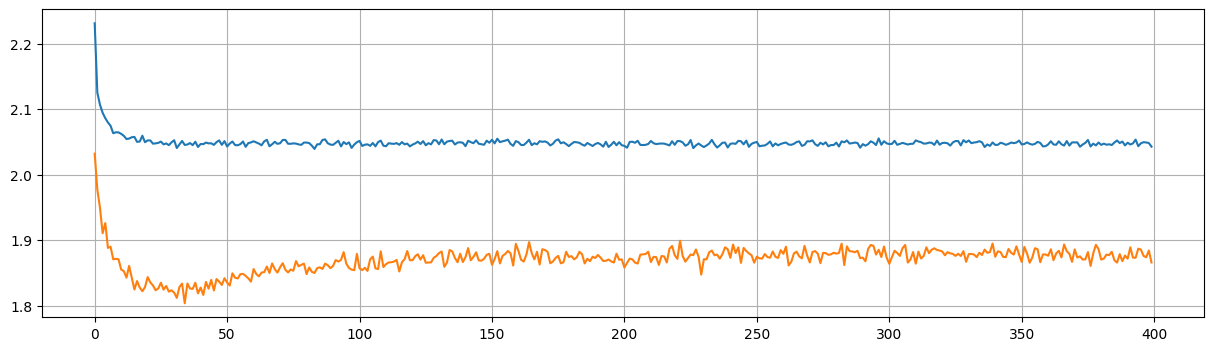

In [ ]:
'''pl.figure(figsize=(15,4))
pl.plot(MLP_Default[0], label='Training Loss')
pl.plot(MLP_Default[1], label='Validation Loss')
pl.grid()'''

In [ ]:
# Predict on the validation set to evaluate the model
'''val_predictions = nn.predict(val_data, dropout_prob=0.0, batch_norm=True)

# Calculate accuracy or other metrics
accuracy = np.mean(val_predictions == val_label)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')'''

Validation Accuracy: 40.74%


HYPERPARAMETER TUNING

In [ ]:
#Tuning Learning Rates
'''
learning_rates = [0.00001, 0.0001, 0.01]
best_accuracy = 0
best_lr = 0

lr_accuracies = []

for lr in learning_rates:
    nn = MLP([128, 64, 64, 10], [None, 'gelu', 'relu', 'softmax'])
    nn.fit(train_data, train_label, val_data, val_label, learning_rate=lr, epochs=400, batch_size=32, weight_decay=0.001, momentum=0.9, dropout_prob=0.5, batch_norm=True)
    val_predictions = nn.predict(val_data, dropout_prob=0.0, batch_norm=True)
    accuracy = np.mean(val_predictions == val_label)
    print(f"Testing LR={lr} gives Validation Accuracy: {accuracy * 100:.2f}%")

    lr_accuracies.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_lr = lr

print(f"Best Learning Rate: {best_lr}")
print(f"Best Validation Accuracy: {best_accuracy * 100:.2f}%")'''

Testing LR=1e-05 gives Validation Accuracy: 36.80%
Testing LR=0.0001 gives Validation Accuracy: 41.23%
Testing LR=0.01 gives Validation Accuracy: 39.52%
Best Learning Rate: 0.0001
Best Validation Accuracy: 41.23%


In [ ]:
#Tuning Weight Decay Factor
'''weight_decays = [0.0, 0.0001, 0.01]
best_accuracy = 0
best_wd = 0

wd_accuracies = []

for wd in weight_decays:
    nn = MLP([128, 64, 64, 10], [None, 'gelu', 'relu', 'softmax'])
    nn.fit(train_data, train_label, val_data, val_label, learning_rate=0.001, epochs=400, batch_size=32, weight_decay=wd, momentum=0.9, dropout_prob=0.5, batch_norm=True)
    val_predictions = nn.predict(val_data, dropout_prob=0.0, batch_norm=True)
    accuracy = np.mean(val_predictions == val_label)
    print(f"Testing wd={wd} gives Validation Accuracy: {accuracy * 100:.2f}%")

    wd_accuracies.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_wd = wd

print(f"Best Weight Decay Value Rate: {best_wd}")
print(f"Best Validation Accuracy: {best_accuracy * 100:.2f}%")'''

Testing wd=0.0 gives Validation Accuracy: 40.93%
Testing wd=0.0001 gives Validation Accuracy: 40.44%
Testing wd=0.01 gives Validation Accuracy: 40.14%
Best Weight Decay Value Rate: 0.0
Best Validation Accuracy: 40.93%


In [ ]:
#Tuning Momentum
'''momentums = [0.85, 0.95, 0.99]
best_accuracy = 0
best_momentum = 0

mom_accuracies = []

for momentum in momentums:
    nn = MLP([128, 64, 64, 10], [None, 'gelu', 'relu', 'softmax'])
    nn.fit(train_data, train_label, val_data, val_label, learning_rate=0.001, epochs=400, batch_size=32, weight_decay=0.001, momentum=momentum, dropout_prob=0.5, batch_norm=True)
    val_predictions = nn.predict(val_data, dropout_prob=0.0, batch_norm=True)
    accuracy = np.mean(val_predictions == val_label)
    print(f"Testing momentum={momentum} gives Validation Accuracy: {accuracy * 100:.2f}%")

    mom_accuracies.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_momentum = momentum

print(f"Best Momentum Value Rate: {best_momentum}")
print(f"Best Validation Accuracy: {best_accuracy * 100:.2f}%")'''

Testing momentum=0.85 gives Validation Accuracy: 41.08%
Testing momentum=0.95 gives Validation Accuracy: 40.43%
Testing momentum=0.99 gives Validation Accuracy: 40.35%
Best Momentum Value Rate: 0.85
Best Validation Accuracy: 41.08%


In [ ]:
#Tuning Dropout Probability
'''dps = [0.0, 0.2, 0.3, 0.6]
best_accuracy = 0
best_dp = 0

dp_accuracies = []

for dp in dps:
    nn = MLP([128, 64, 64, 10], [None, 'gelu', 'relu', 'softmax'])
    nn.fit(train_data, train_label, val_data, val_label, learning_rate=0.001, epochs=400, batch_size=32, weight_decay=0.001, momentum=0.9, dropout_prob=dp, batch_norm=True)
    val_predictions = nn.predict(val_data, dropout_prob=0.0, batch_norm=True)
    accuracy = np.mean(val_predictions == val_label)
    print(f"Testing Dropout Probability ={dp} gives Validation Accuracy: {accuracy * 100:.2f}%")

    dp_accuracies.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dp = dp

print(f"Best Dropout Probability: {best_dp}")
print(f"Best Validation Accuracy: {best_accuracy * 100:.2f}%")'''

Testing Dropout Probability =0.0 gives Validation Accuracy: 50.21%
Testing Dropout Probability =0.2 gives Validation Accuracy: 50.50%
Testing Dropout Probability =0.3 gives Validation Accuracy: 46.29%
Testing Dropout Probability =0.6 gives Validation Accuracy: 39.10%
Best Dropout Probability: 0.2
Best Validation Accuracy: 50.50%


In [ ]:
#Tuning Batch Sizes
'''batch_sizes = [16, 64, 128]
best_accuracy = 0
best_size = 0

sizes_accuracies = []

for bs in batch_sizes:
    nn = MLP([128, 64, 64, 10], [None, 'gelu', 'relu', 'softmax'])
    nn.fit(train_data, train_label, val_data, val_label, learning_rate=0.001, epochs=400, batch_size=bs, weight_decay=0.001, momentum=0.9, dropout_prob=0.5, batch_norm=True)
    val_predictions = nn.predict(val_data, dropout_prob=0.0, batch_norm=True)
    accuracy = np.mean(val_predictions == val_label)
    print(f"Testing Batch Sizes ={bs} gives Validation Accuracy: {accuracy * 100:.2f}%")

    sizes_accuracies.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_size = bs

print(f"Best Batch Size: {best_size}")
print(f"Best Validation Accuracy: {best_accuracy * 100:.2f}%")'''

Testing Batch Sizes =16 gives Validation Accuracy: 40.72%
Testing Batch Sizes =64 gives Validation Accuracy: 40.71%
Testing Batch Sizes =128 gives Validation Accuracy: 40.64%
Best Batch Size: 16
Best Validation Accuracy: 40.72%


In [ ]:
#Tuning Node Counts
'''node_counts = [[64,32],[128,64]]
best_accuracy = 0
best_count = 0

count_accuracies = []

for nc in node_counts:
    nn = MLP([128, nc[0], nc[1], 10], [None, 'gelu', 'relu', 'softmax'])
    nn.fit(train_data, train_label, val_data, val_label, learning_rate=0.001, epochs=400, batch_size=32, weight_decay=0.001, momentum=0.9, dropout_prob=0.5, batch_norm=True)
    val_predictions = nn.predict(val_data, dropout_prob=0.0, batch_norm=True)
    accuracy = np.mean(val_predictions == val_label)
    print(f"Testing Node Count ={nc} gives Validation Accuracy: {accuracy * 100:.2f}%")

    count_accuracies.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_count = nc

print(f"Best Node Count Set: {best_count}")
print(f"Best Validation Accuracy: {best_accuracy * 100:.2f}%")'''

Testing Node Count =[64, 32] gives Validation Accuracy: 39.93%
Testing Node Count =[128, 64] gives Validation Accuracy: 43.50%
Best Node Count Set: [128, 64]
Best Validation Accuracy: 43.50%


In [ ]:
#Tuning Activations
'''activations = [['gelu','gelu'],['relu','gelu'],['relu','relu']]
best_accuracy = 0
best_activ = 0

act_accuracies = []

for activ in activations:
    nn = MLP([128, 64, 64, 10], [None, activ[0], activ[1], 'softmax'])
    nn.fit(train_data, train_label, val_data, val_label, learning_rate=0.001, epochs=400, batch_size=32, weight_decay=0.001, momentum=0.9, dropout_prob=0.5, batch_norm=True)
    val_predictions = nn.predict(val_data, dropout_prob=0.0, batch_norm=True)
    accuracy = np.mean(val_predictions == val_label)
    print(f"Testing activations ={activ} gives Validation Accuracy: {accuracy * 100:.2f}%")

    act_accuracies.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_activ = activ

print(f"Best Activation Set: {best_activ}")
print(f"Best Validation Accuracy: {best_accuracy * 100:.2f}%")'''

Testing activations =['gelu', 'gelu'] gives Validation Accuracy: 39.75%
Testing activations =['relu', 'gelu'] gives Validation Accuracy: 44.29%
Testing activations =['relu', 'relu'] gives Validation Accuracy: 47.02%
Best Activation Set: ['relu', 'relu']
Best Validation Accuracy: 47.02%


In [19]:
#Without Batch Normalization
'''nn = MLP([128, 64, 64, 10], [None, 'gelu', 'relu', 'softmax'])
MLP_nobatch = nn.fit(train_data, train_label, val_data, val_label, learning_rate=0.001, epochs=400, batch_size=32, weight_decay=0.001, momentum=0.9, dropout_prob=0.5, batch_norm=False)
val_predictions = nn.predict(val_data, dropout_prob=0.0, batch_norm=False)

accuracy = np.mean(val_predictions == val_label)
print(f'Without Batch Normalization - Validation Accuracy: {accuracy * 100:.2f}%')


#With Batch Normalization
nn = MLP([128, 64, 64, 10], [None, 'gelu', 'relu', 'softmax'])
MLP_batch = nn.fit(train_data, train_label, val_data, val_label, learning_rate=0.001, epochs=400, batch_size=32, weight_decay=0.001, momentum=0.9, dropout_prob=0.5, batch_norm=True)
val_predictions = nn.predict(val_data, dropout_prob=0.0, batch_norm=True)

accuracy = np.mean(val_predictions == val_label)
print(f'With Batch Normalization - Validation Accuracy: {accuracy * 100:.2f}%')'''

Without Batch Normalization - Validation Accuracy: 10.33%
With Batch Normalization - Validation Accuracy: 41.36%


In [20]:
#With One Hidden Layer
'''nn = MLP([128, 64, 10], [None, 'gelu', 'softmax'])
MLP_one = nn.fit(train_data, train_label, val_data, val_label, learning_rate=0.001, epochs=400, batch_size=32, weight_decay=0.001, momentum=0.9, dropout_prob=0.5, batch_norm=True)
val_predictions = nn.predict(val_data, dropout_prob=0.0, batch_norm=False)

accuracy = np.mean(val_predictions == val_label)
print(f'With One Hidden Layer - Validation Accuracy: {accuracy * 100:.2f}%')


#With Three Hidden Layers
nn = MLP([128, 64, 64, 64, 10], [None, 'gelu', 'relu', 'relu', 'softmax'])
MLP_three = nn.fit(train_data, train_label, val_data, val_label, learning_rate=0.001, epochs=400, batch_size=32, weight_decay=0.001, momentum=0.9, dropout_prob=0.5, batch_norm=True)
val_predictions = nn.predict(val_data, dropout_prob=0.0, batch_norm=True)

accuracy = np.mean(val_predictions == val_label)
print(f'With Three Hidden Layers - Validation Accuracy: {accuracy * 100:.2f}%')'''

With One Hidden Layer - Validation Accuracy: 33.06%
With Three Hidden Layers - Validation Accuracy: 41.15%


FINAL MODEL

In [25]:
#The Final Model with the best performing hyperparameters

nn = MLP([128,128,64,10], [None,'relu','relu','softmax'])

MLP_final = nn.fit(train_data, train_label, val_data, val_label, learning_rate=0.0001, epochs=400, batch_size=32, weight_decay = 0.001, momentum = 0.85, dropout_prob=0.2, batch_norm = True)

val_predictions = nn.predict(val_data, dropout_prob=0.0, batch_norm=True)


accuracy = np.mean(val_predictions == val_label)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Validation Accuracy: 55.16%


training loss:1.435070
validation loss:1.296003


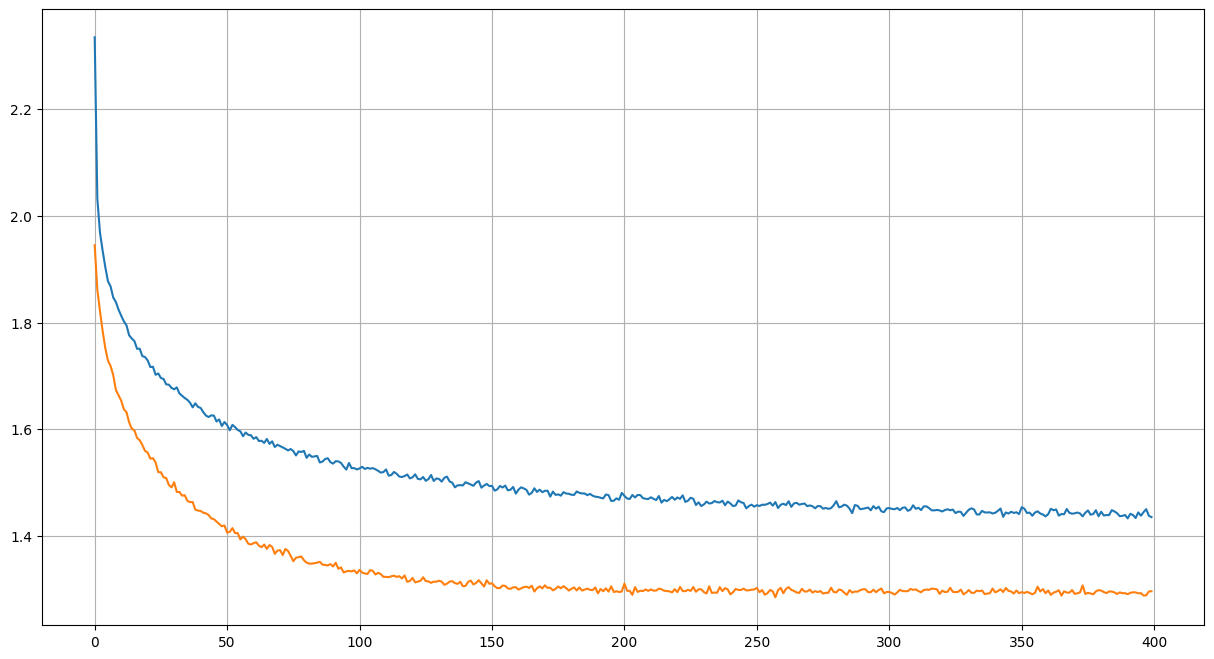

In [22]:
pl.figure(figsize=(15,8))
pl.plot(MLP_final[0])
pl.plot(MLP_final[1])
pl.grid()

print('training loss:%f'%MLP_final[0][-1]) #blue
print('validation loss:%f'%MLP_final[1][-1]) #orange

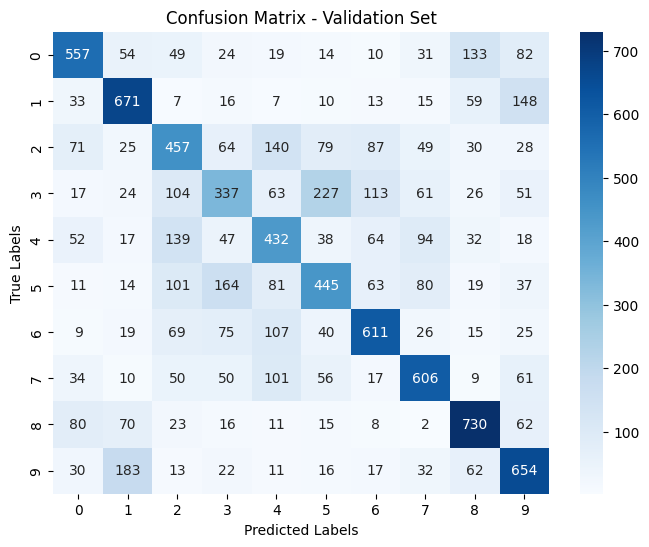

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

# Confusion matrix for validation set
val_cm = confusion_matrix(val_label, val_predictions)
pl.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues')
pl.xlabel('Predicted Labels')
pl.ylabel('True Labels')
pl.title('Confusion Matrix - Validation Set')
pl.show()

In [15]:
#Classification report for validation set
val_report = classification_report(val_label, val_predictions)
print("Classification Report - Validation Set:")
print(val_report)

Classification Report - Validation Set:
              precision    recall  f1-score   support

           0       0.62      0.57      0.60       973
           1       0.62      0.69      0.65       979
           2       0.45      0.44      0.45      1030
           3       0.41      0.33      0.37      1023
           4       0.44      0.46      0.45       933
           5       0.47      0.44      0.46      1015
           6       0.61      0.61      0.61       996
           7       0.61      0.61      0.61       994
           8       0.65      0.72      0.68      1017
           9       0.56      0.63      0.59      1040

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.55      0.55      0.55     10000



In [26]:
test_predictions = nn.predict(test_data_norm, dropout_prob=0.0, batch_norm=True)

test_accuracy = np.mean(test_predictions == test_label_source)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

print("Comparing the last 10 predictions and actual labels:")
for pred, actual in zip(test_predictions[-10:], test_label_source[-10:]):
    print(f"Predicted: {pred}, Actual: {actual}")

Test Accuracy: 55.04%
Comparing the last 10 predictions and actual labels:
Predicted: [7.], Actual: [7]
Predicted: [9.], Actual: [0]
Predicted: [5.], Actual: [3]
Predicted: [7.], Actual: [5]
Predicted: [3.], Actual: [3]
Predicted: [8.], Actual: [8]
Predicted: [5.], Actual: [3]
Predicted: [3.], Actual: [5]
Predicted: [2.], Actual: [1]
Predicted: [7.], Actual: [7]


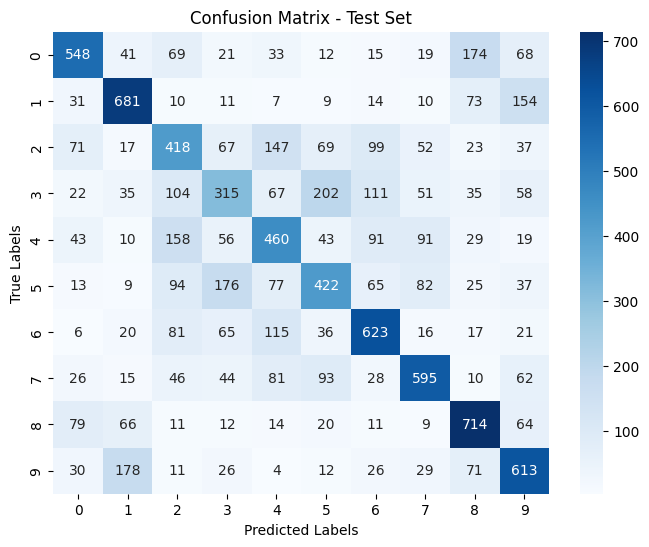

In [17]:
# Confusion matrix for test set
test_cm = confusion_matrix(test_label_source, test_predictions)
pl.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
pl.xlabel('Predicted Labels')
pl.ylabel('True Labels')
pl.title('Confusion Matrix - Test Set')
pl.show()

In [18]:
#Classification report for test set
test_report = classification_report(test_label_source, test_predictions)
print("Classification Report - Test Set:")
print(test_report)

Classification Report - Test Set:
              precision    recall  f1-score   support

           0       0.63      0.55      0.59      1000
           1       0.64      0.68      0.66      1000
           2       0.42      0.42      0.42      1000
           3       0.40      0.32      0.35      1000
           4       0.46      0.46      0.46      1000
           5       0.46      0.42      0.44      1000
           6       0.58      0.62      0.60      1000
           7       0.62      0.59      0.61      1000
           8       0.61      0.71      0.66      1000
           9       0.54      0.61      0.57      1000

    accuracy                           0.54     10000
   macro avg       0.53      0.54      0.54     10000
weighted avg       0.53      0.54      0.54     10000

